# ДЗ1. Классификация текстов и тематическое моделирование

В этом домашнем задании вам предстоит построить классификатор текстов и проанализировать их содержание. Мы будем предсказывать эмоциональную окраску (позитив/негатив) твиттов о коронавирусе, а также выделять основные темы обсуждения.

В ходе работы вы пройдете весь NLP-пайплайн:

1.  **Предобработка.** Токенизация, очистка от шума, стемминг и лемматизация.
2.  **Векторизация.** Построение признаков методами Bag-of-Words и TF-IDF.
3.  **Классификация.** Обучение логистической регрессии и анализ важности признаков.
4.  **Тематическое моделирование.** Выделение скрытых тем в твиттах с помощью LDA.
5.  **Эмбеддинги.** Использование плотных векторных представлений (Word2Vec) для классификации.

Вот несколько правил, который помогут нам сделать работу приятнее и продуктивнее:

* Домашнее задание оценивается в 11 баллов.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.
* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них. Если в работе вы используете генеративные модели, их указание обязательно.
* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

## Setting

In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [3]:
!wget  -O 'tweets.csv' -q 'https://www.dropbox.com/scl/fi/9aa3ayx7ax3uy1r04lgsn/tweets.csv?rlkey=svfde8wc04ayvqnkwhwb6jm04&st=wgvibiqc&dl=0'

In [4]:
df = pd.read_csv('tweets.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30505,41310,86262,NaN,10-04-2020,Did members of #TablighiJamaat demand non-vege...,Negative
24927,34314,79266,"California, USA",06-04-2020,1/2\r\r\nGrocery workers are beginning to die ...,Extremely Negative
22378,31140,76092,Michigan | Ohio | Kentucky | Indiana | Canada,03-04-2020,HOMESCHOOL ISN'T JUST FOR KIDS. | Grow Your #B...,Extremely Positive
21771,30372,75324,London & Edinburgh,02-04-2020,We propose temporary financial relief for cust...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [5]:
df["Sentiment"].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [6]:
df['Sentiment_binary'] = df['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)

Сбалансированы ли классы?

In [7]:
df['Sentiment_binary'].value_counts()

1    18046
0    15398
Name: Sentiment_binary, dtype: int64

In [8]:
df['Sentiment_binary'].value_counts(normalize=True)

1    0.539589
0    0.460411
Name: Sentiment_binary, dtype: float64

**Ответ:** баланс классов нормальный, 54 / 46



Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [9]:
print(df.isnull().sum())

UserName               0
ScreenName             0
Location            7049
TweetAt                0
OriginalTweet          0
Sentiment              0
Sentiment_binary       0
dtype: int64


In [10]:
df.fillna('Unknown', inplace=True)

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0) # your code here [✖‿✖]

## Задание 2 Токенизация (2 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [12]:
from collections import Counter

word_counts = Counter()

for text in train['OriginalTweet']:
    tokens = str(text).lower().split()
    word_counts.update(tokens)

Какой размер словаря получился?

In [13]:
len(word_counts)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [14]:
sorted(word_counts.items(), key=lambda x: -x[1])[:10]

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** 79755, связывающие слова в англ. языке

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [15]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/karpov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/karpov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('english'))
clean_word_counts = {}
for text in train['OriginalTweet']:
    tokens = text.lower().split()
    for token in tokens:
        if token not in stop_words:
            clean_word_counts[token] = clean_word_counts.get(token, 0) + 1

In [17]:
sorted(clean_word_counts.items(), key=lambda x: -x[1])[:10]

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  появились новые тематические слова

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [18]:
sorted(clean_word_counts.items(), key=lambda x: x[1])[:20]

[('https://t.co/1m881cwfuv', 1),
 ('happy..', 1),
 ('https://t.co/z0intks34x', 1),
 ('mnuchinã\x82â\x92s', 1),
 ('brink.', 1),
 ('https://t.co/jmobv8z0u0', 1),
 ("university's", 1),
 ('teaching.)', 1),
 ('@catholicpres', 1),
 ('@catholicuniv', 1),
 ('https://t.co/evqby035wf', 1),
 ('https://t.co/riqrhxxeim', 1),
 ('@@ballardspahrll', 1),
 ('#aca', 1),
 ('easier...take', 1),
 ('ã\x82â\x93necessaryã\x82â\x94', 1),
 ('https://t.co/0fmsmlgepm', 1),
 ('husted:', 1),
 ('irishman', 1),
 ('#happystpatricksday!', 1)]

**Ответ:** встречаются редкие слова и ссылки, можно обработать их, как минимальное встречающиеся по условию < 1

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [19]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()
tweet_word_counts = {}

for text in train['OriginalTweet']:
    tokens = tweet_tokenizer.tokenize(text.lower())
    for token in tokens:
        tweet_word_counts[token] = tweet_word_counts.get(token, 0) + 1


In [20]:
sorted(tweet_word_counts.items(), key=lambda x: -x[1])[:10]

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** TweetTokenize отделил знаки препинания

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [21]:
from string import punctuation

stop_words = set(stopwords.words('english')).union(set(punctuation))
tweet_clean_counts = {}

for text in train['OriginalTweet']:
    tokens = tweet_tokenizer.tokenize(text.lower())
    for token in tokens:
        if token not in stop_words:
            tweet_clean_counts[token] = tweet_clean_counts.get(token, 0) + 1

In [22]:
sorted(tweet_clean_counts.items(), key=lambda x: -x[1])[:10]

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** встретились непонятные слова (\x82, \x92) и числа 19

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [23]:
final_counts = {}
for token, count in tweet_clean_counts.items():
    if len(token) == 1 and ord(token) >= 128:
        continue
    final_counts[token] = count

In [24]:
sorted(final_counts.items(), key=lambda x: -x[1])[:10]

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [25]:
sorted(final_counts.items(), key=lambda x: x[1])[:20]

[('https://t.co/1m881cwfuv', 1),
 ('https://t.co/z0intks34x', 1),
 ('mnuchinã', 1),
 ('https://t.co/jmobv8z0u0', 1),
 ("university's", 1),
 ('@catholicpres', 1),
 ('@catholicuniv', 1),
 ('https://t.co/evqby035wf', 1),
 ('https://t.co/riqrhxxeim', 1),
 ('@ballardspahrll', 1),
 ('#aca', 1),
 ('https://t.co/0fmsmlgepm', 1),
 ('irishman', 1),
 ('#happystpatricksday', 1),
 ('guiness', 1),
 ('https://t.co/18v0pyhwb7', 1),
 ('https://t.co/ls0g86i8pu', 1),
 ('https://t.co/ofvkejff23', 1),
 ('https://t.co/xoodgd2ulx', 1),
 ('lifestyles', 1)]

**Ответ:** TweetTokenizer дает более чистые результаты и лучше обрабатывает хештеги, знаки препинания

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [26]:
hashtags = {token: count for token, count in final_counts.items() if token.startswith('#')}
sorted(hashtags.items(), key=lambda x: -x[1])[:10]

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** отражают популярные темы обсуждения

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [27]:
links = {token: count for token, count in final_counts.items() if 't.co' in token}
sorted(links.items(), key=lambda x: -x[1])[:10]

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** cсылки менее популярны, так как обычно уникальны для каждого твита

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [28]:
def custom_tokenizer(text):

    text = text.lower()

    tokens = tweet_tokenizer.tokenize(text)
    
    filtered = []
    for token in tokens:
        if token in stop_words:
            continue
            
        if len(token) == 1 and ord(token) >= 128:
            continue
            
        if 't.co' in token:
            continue
            
        filtered.append(token)
    
    return filtered

In [29]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (1 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
X_train_cv = cv.fit_transform(train['OriginalTweet'])

len_cv = len(cv.vocabulary_)

print(f"Размер без custom_tokenizer = {len(word_counts)}") # 45308
print(f"Размер с custom_tokenizer = {len(cv.vocabulary_)}") # 45308

Размер без custom_tokenizer = 79755
Размер с custom_tokenizer = 45279


**Ответ:** изначальный словрь был 79755, текущий словарь сильно меньше 45279. убрали ненужные токены в виде пунктуации, стоп-слов

Посмотрим на какой-нибудь конкретный твитт:

In [31]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 'Negative')

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [32]:
sample_text = train.iloc[ind]['OriginalTweet']
print(f"Текст: {sample_text}")

sample_vector_cv = cv.transform([sample_text])

non_zero_indices = sample_vector_cv.nonzero()[1]
non_zero_values = sample_vector_cv.data

if len(non_zero_values) > 0:
    max_idx = non_zero_values.argmax()
    min_idx = non_zero_values.argmin()
    
    feature_names = cv.get_feature_names_out()
    
    max_token = feature_names[non_zero_indices[max_idx]]
    max_value = non_zero_values[max_idx]
    
    min_token = feature_names[non_zero_indices[min_idx]]
    min_value = non_zero_values[min_idx]
    
    print(f"\nСамый важный токен: '{max_token}' (вес: {max_value})")
    print(f"Самый неважный токен: '{min_token}' (вес: {min_value})")
else:
    print("Все компоненты равны 0")

Текст: Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs

Самый важный токен: '#coronavirusoutbreak' (вес: 1)
Самый неважный токен: '#coronavirusoutbreak' (вес: 1)


**Ответ:** не хорошо, так как токены одинаковые, но CountVectorizer подсчитывает кол-во вхождений, поэтому в данном случае все закономерно

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(f"Текст: {train.iloc[ind]['OriginalTweet']}")

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tfidf = tfidf.fit_transform(train['OriginalTweet'])

sample_vector_tfidf = tfidf.transform([sample_text])

non_zero_indices_tf = sample_vector_tfidf.nonzero()[1]
non_zero_values_tf = sample_vector_tfidf.data

if len(non_zero_values_tf) > 0:
    max_idx_tf = non_zero_values_tf.argmax()
    min_idx_tf = non_zero_values_tf.argmin()
    
    feature_names_tf = tfidf.get_feature_names_out()
    
    max_token_tf = feature_names_tf[non_zero_indices_tf[max_idx_tf]]
    max_value_tf = non_zero_values_tf[max_idx_tf]
    
    min_token_tf = feature_names_tf[non_zero_indices_tf[min_idx_tf]]
    min_value_tf = non_zero_values_tf[min_idx_tf]
    
    print(f"\nСамый важный токен: '{max_token_tf}' (вес: {max_value_tf:.4f})")
    print(f"Самый неважный токен: '{min_token_tf}' (вес: {min_value_tf:.4f})")
else:
    print("Все компоненты равны 0")

Текст: Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs

Самый важный токен: 'brainless' (вес: 0.3868)
Самый неважный токен: 'food' (вес: 0.1133)


**Ответ:** здесь уже виден паттер выделения редких токенов

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [34]:
train[train['OriginalTweet'].apply(lambda x: 'your_good_word_here' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_binary


In [35]:
positive_tweets = train[train['OriginalTweet'].str.contains('good', case=False) & (train['Sentiment_binary'] == 1)]

In [36]:
sample_positive = positive_tweets.iloc[0]
print(f"Текст: {sample_positive['OriginalTweet']}")

pos_vector = tfidf.transform([sample_positive['OriginalTweet']])
non_zero = pos_vector.nonzero()

if len(non_zero[1]) > 0:
    feature_names = tfidf.get_feature_names_out()
    values = pos_vector.data
    max_idx = np.argmax(values)
    max_token = feature_names[non_zero[1][max_idx]]
    max_value = values[max_idx]
        
    print(f"\nСамый важный токен: '{max_token}' (вес: {max_value:.4f})")

Текст: To all my marketers friends, this is a very good article by @McKinsey regarding customer sentiment during the #coronavirus crisis. Are you ready to change your whole marketing strategy? #MarketingStrategy 
https://t.co/plN1H6qYLw

Самый важный токен: '#marketingstrategy' (вес: 0.3742)


**Ответ:** в данном случае TF-IDF хорошо определил смысл слова и выделил токен

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [37]:
X_test_cv = cv.transform(test['OriginalTweet'])
X_test_tfidf = tfidf.transform(test['OriginalTweet'])

y_train = train['Sentiment_binary']
y_test = test['Sentiment_binary']

print(f"Размер обучающей выборки: {X_train_cv.shape}")
print(f"Размер тестовой выборки: {X_test_cv.shape}")

Размер обучающей выборки: (23410, 45279)
Размер тестовой выборки: (10034, 45279)


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1)
lr_cv.fit(X_train_cv, y_train)

pred_train_cv = lr_cv.predict(X_train_cv)
pred_test_cv = lr_cv.predict(X_test_cv)

train_acc_cv = accuracy_score(y_train, pred_train_cv)
test_acc_cv = accuracy_score(y_test, pred_test_cv)

lr_tfidf = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1)
lr_tfidf.fit(X_train_tfidf, y_train)

pred_train_tfidf = lr_tfidf.predict(X_train_tfidf)
pred_test_tfidf = lr_tfidf.predict(X_test_tfidf)

train_acc_tfidf = accuracy_score(y_train, pred_train_tfidf)
test_acc_tfidf = accuracy_score(y_test, pred_test_tfidf)

print("Результаты CountVectorizer:")
print(f"Обучающая выборка accuracy: {train_acc_cv:.6f}")
print(f"Тестовая выборка accuracy: {test_acc_cv:.6f}")

print("\nРезультаты TF-IDF:")
print(f"Обучающая выборка accuracy: {train_acc_tfidf:.6f}")
print(f"Тестовая выборка accuracy: {test_acc_tfidf:.6f}")

Результаты CountVectorizer:
Обучающая выборка accuracy: 0.984451
Тестовая выборка accuracy: 0.867251

Результаты TF-IDF:
Обучающая выборка accuracy: 0.925502
Тестовая выборка accuracy: 0.854096


**Ответ:** в данном случае CountVectorizer результат лучше, чем TF-IDF, однако размеца между обучающей метрикой и тестовой у TF-IDF лучше

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [39]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

In [40]:
def custom_stem_tokenizer(text):
    tokens = custom_tokenizer(text)
    
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

In [41]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')
# ['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [42]:
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer, lowercase=False)
cv_stem.fit(train['OriginalTweet'])

print(f"Размер без стемминга = {len_cv}")
print(f"Размер со стеммингом = {len(cv_stem.vocabulary_)}")
# эталлон 36652

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Размер без стемминга = 45279
Размер со стеммингом = 36623


**Ответ** словарь стал меньше, с 45279 стал 36623

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
X_train_cv_stem = cv_stem.transform(train['OriginalTweet'])
X_test_cv_stem = cv_stem.transform(test['OriginalTweet'])

tfidf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer, lowercase=False)
X_train_tfidf_stem = tfidf_stem.fit_transform(train['OriginalTweet'])
X_test_tfidf_stem = tfidf_stem.transform(test['OriginalTweet'])

y_train = train['Sentiment_binary']
y_test = test['Sentiment_binary']

In [45]:
logreg_cv_stem = LogisticRegression(max_iter=1000, solver="liblinear")
logreg_cv_stem.fit(X_train_cv_stem, y_train)

y_train_cv_stem_pred = logreg_cv_stem.predict(X_train_cv_stem)
y_test_cv_stem_pred = logreg_cv_stem.predict(X_test_cv_stem)

print("Результаты CountVectorizer:")
print(f"CountVectorizer и стемминг train: {accuracy_score(y_train, y_train_cv_stem_pred):.6}")
print(f"CountVectorizer и стемминг test: {accuracy_score(y_test, y_test_cv_stem_pred):.6}")

logreg_tfidf_stem = LogisticRegression(max_iter=1000, solver="liblinear")
logreg_tfidf_stem.fit(X_train_tfidf_stem, y_train)

y_train_tfidf_stem_pred = logreg_tfidf_stem.predict(X_train_tfidf_stem)
y_test_tfidf_stem_pred = logreg_tfidf_stem.predict(X_test_tfidf_stem)

print("\nРезультаты TF-IDF:")
print(f"TF-IDF и стемминг train: {accuracy_score(y_train, y_train_tfidf_stem_pred):.6}")
print(f"TF-IDF и стемминг test: {accuracy_score(y_test, y_test_tfidf_stem_pred):.6}")

Результаты CountVectorizer:
CountVectorizer и стемминг train: 0.971721
CountVectorizer и стемминг test: 0.867451

Результаты TF-IDF:
TF-IDF и стемминг train: 0.916275
TF-IDF и стемминг test: 0.856289


**Ответ:** метрики для обучения чуть ухудшились, а для теста увеличились 

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36622 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [46]:
cv_base = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
cv_base.fit(train['OriginalTweet'])
base_size = len(cv_base.vocabulary_)
print(f"Исходный размер словаря: {base_size}")

X_train_base = cv_base.transform(train['OriginalTweet'])
doc_freq = np.asarray((X_train_base > 0).sum(axis=0)).ravel()

target_vocab = 36622
unique_dfs = np.unique(doc_freq)
best_thr = None
best_diff = float('inf')

for thr in unique_dfs:
    kept = np.sum(doc_freq <= thr)
    diff = abs(kept - target_vocab)
    
    if diff < best_diff:
        best_diff = diff
        best_thr = thr
        if diff == 0:
            break

print(f"Лучший порог: {best_thr}")

Исходный размер словаря: 36623
Лучший порог: 6985


In [47]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df = 6985).fit(train['OriginalTweet'])

print(len(cv_df.vocabulary_)) # эталлон 36651

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36622


**Ответ:** можно выкинуть токен, который встречается 6985, значение большое

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [48]:
cv_base = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
cv_base.fit(train['OriginalTweet'])
X_train_base = cv_base.transform(train['OriginalTweet'])
doc_freq = np.asarray((X_train_base > 0).sum(axis=0)).ravel()

target_vocab = 3700
unique_dfs = np.unique(doc_freq)
best_min_df = None
best_diff = float('inf')

for freq in unique_dfs:
    kept = np.sum(doc_freq >= freq)
    diff = abs(kept - target_vocab)
    
    if diff < best_diff:
        best_diff = diff
        best_min_df = freq
        if diff == 0:
            break
            
print(f"Лучший порог: {best_min_df}")         

Лучший порог: 11


In [49]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(train['OriginalTweet'])

print(len(cv_df.vocabulary_))

3687


In [50]:
X_train_cv_min = cv_df.transform(train['OriginalTweet'])
X_test_cv_min = cv_df.transform(test['OriginalTweet'])

logreg_cv_min = LogisticRegression(max_iter=1000, solver="liblinear")
logreg_cv_min.fit(X_train_cv_min, y_train)

print("train:", accuracy_score(y_train, logreg_cv_min.predict(X_train_cv_min)))
print("test:", accuracy_score(y_test, logreg_cv_min.predict(X_test_cv_min)))

train: 0.9287483981204614
test: 0.8684472792505481


**Ответ:** метрика в test не так сильно просела, хотя объем сократился значительно,  результат хороший!

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_cv_min)
X_test_scaled = scaler.transform(X_test_cv_min)

logreg_scaled = LogisticRegression(max_iter=1000, solver="liblinear")
logreg_scaled.fit(X_train_scaled, y_train)

train_acc_scaled = accuracy_score(y_train, logreg_scaled.predict(X_train_scaled))
test_acc_scaled = accuracy_score(y_test, logreg_scaled.predict(X_test_scaled))

print(f"Train accuracy (со скалированием): {train_acc_scaled:.6f}")
print(f"Test accuracy (со скалированием): {test_acc_scaled:.6f}")

Train accuracy (со скалированием): 0.941350
Test accuracy (со скалированием): 0.844628


In [52]:
feature_names = cv_df.get_feature_names_out()
coefficients = logreg_scaled.coef_[0]

positive_indices = np.argsort(coefficients)[-10:][::-1]
print("Топ-10 токенов с положительными весами:")
for idx in positive_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

negative_indices = np.argsort(coefficients)[:10]
print("\nТоп-10 токенов с отрицательными весами:")
for idx in negative_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

Топ-10 токенов с положительными весами:
hand: 1.2304
free: 1.1072
help: 1.0753
thank: 1.0364
like: 0.9258
best: 0.9082
pleas: 0.8386
great: 0.8103
safe: 0.7859
support: 0.7298

Топ-10 токенов с отрицательными весами:
crisi: -1.7406
panic: -1.2963
scam: -1.0707
kill: -0.7499
crude: -0.6158
stop: -0.5996
fear: -0.5685
emerg: -0.5583
wtf: -0.5569
fight: -0.5417


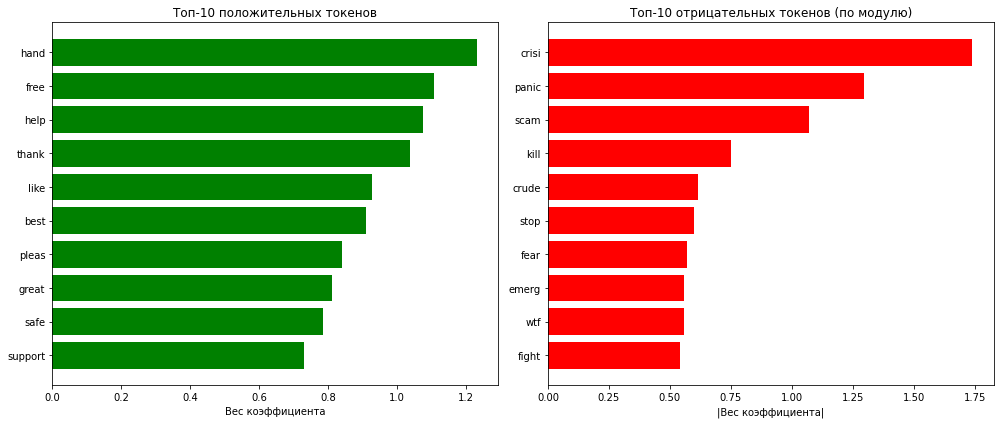

In [53]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

positive_tokens = [feature_names[i] for i in positive_indices]
positive_weights = [coefficients[i] for i in positive_indices]
bars1 = ax1.barh(range(10), positive_weights, color='green')
ax1.set_yticks(range(10))
ax1.set_yticklabels(positive_tokens)
ax1.set_xlabel('Вес коэффициента')
ax1.set_title('Топ-10 положительных токенов')
ax1.invert_yaxis()

negative_tokens = [feature_names[i] for i in negative_indices]
negative_weights = [abs(coefficients[i]) for i in negative_indices]
bars2 = ax2.barh(range(10), negative_weights, color='red')
ax2.set_yticks(range(10))
ax2.set_yticklabels(negative_tokens)
ax2.set_xlabel('|Вес коэффициента|')
ax2.set_title('Топ-10 отрицательных токенов (по модулю)')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

**Ответ:** видно, что токены получились смысловые. однако видны немного искаженные формы слов

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. Полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [54]:
print("Уникальных UserName:", train['UserName'].nunique())
print("Уникальных ScreenName:", train['ScreenName'].nunique())

Уникальных UserName: 23410
Уникальных ScreenName: 23410


**Ответ:** UserName и ScreenName неинформативны, так как много уникальных значений

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

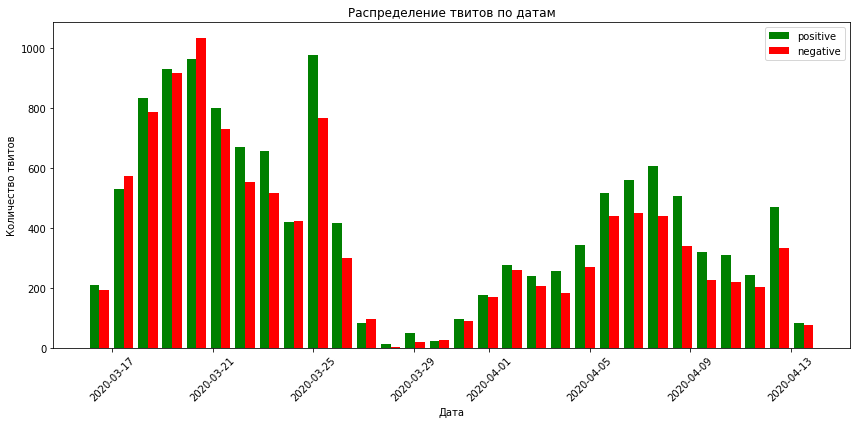

In [55]:
import matplotlib.pyplot as plt

train['TweetAt_dt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')

plt.figure(figsize=(12, 6))

positive_dates = train[train['Sentiment_binary'] == 1]['TweetAt_dt']
negative_dates = train[train['Sentiment_binary'] == 0]['TweetAt_dt']

plt.hist([positive_dates, negative_dates], bins= 30, label=["positive", "negative"], color=['green', 'red'])

plt.xlabel('Дата')
plt.ylabel('Количество твитов')
plt.title('Распределение твитов по датам')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Ответ:** признак TweetAt показывает некоторую закономерность - пики твитов соответствуют событиям пандемии, распределение положительных и отрицательных примерно одинаковое, поэтому не будет включать в модель

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [56]:
print("Уникальных значений Location:", train['Location'].nunique())

Уникальных значений Location: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

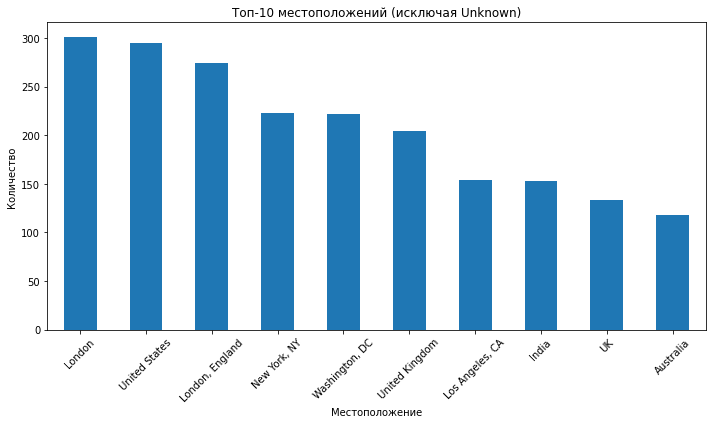

In [57]:
top_locations = train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar')
plt.title('Топ-10 местоположений (исключая Unknown)')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [58]:
def extract_wider_location(loc):
    if loc == 'Unknown':
        return 'Unknown'
    parts = loc.split(',')
    return parts[-1].strip() if len(parts) > 1 else loc

train['WiderLocation'] = train['Location'].apply(extract_wider_location)
test['WiderLocation'] = test['Location'].apply(extract_wider_location)

print("Уникальных WiderLocation:", train['WiderLocation'].nunique())

Уникальных WiderLocation: 4766


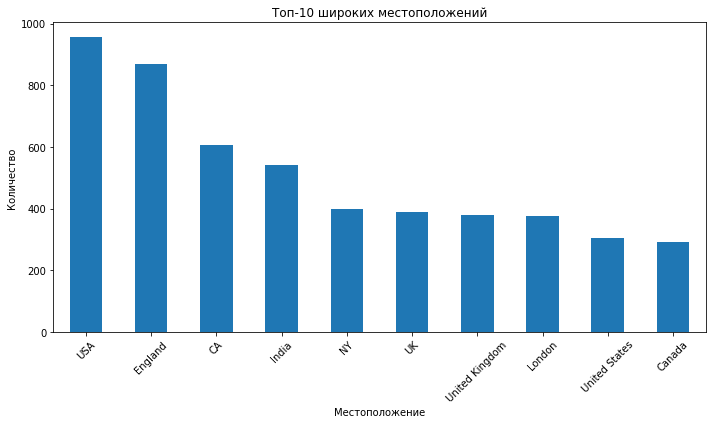

In [59]:
top_wider = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_wider.plot(kind='bar')
plt.title('Топ-10 широких местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [60]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

location_counts = train['WiderLocation'].value_counts()
frequent_locations = location_counts[location_counts > 1].index.tolist()

encoder = OneHotEncoder(categories=[frequent_locations], handle_unknown='ignore')
train_location_encoded = encoder.fit_transform(train[['WiderLocation']])
test_location_encoded = encoder.transform(test[['WiderLocation']])

print(f"Количество частых локаций: {len(frequent_locations)}")

Количество частых локаций: 1005


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [61]:
X_train_combined = hstack([X_train_scaled, train_location_encoded])
X_test_combined = hstack([X_test_scaled, test_location_encoded])

logreg_combined = LogisticRegression(max_iter=1000, solver="liblinear")
logreg_combined.fit(X_train_combined, y_train)

train_acc_combined = accuracy_score(y_train, logreg_combined.predict(X_train_combined))
test_acc_combined = accuracy_score(y_test, logreg_combined.predict(X_test_combined))

print(f"Train accuracy: {train_acc_combined:.6f}")
print(f"Test accuracy: {test_acc_combined:.6f}")
print(f"Test accuracy без Location: {test_acc_scaled:.6f}")

Train accuracy: 0.945152
Test accuracy: 0.843831
Test accuracy без Location: 0.844628


**Ответ:** признак Location оказался не полезным для классификации тональности - качество на тестовой выборке немного уменьшилось. объясняется тем, что местоположение пользователя слабо коррелирует с тональностью твита о коронавирус

## Задание 8 LSA/LSI через SVD: сжатие и качество (1 балл)

TF-IDF векторы - это очень высокоразмерные и разреженные признаки. Метод LSA (Latent Semantic Analysis) или LSI (Latent Semantic Indexing), которые мы проходили на семинаре, позволяет найти скрытые связи между словами и документами, сжимая матрицу до меньшей размерности $k$. Это делается с помощью SVD-разложения. Иногда это даже улучшает качество классификации, так как убирает шум.

Подготовим TF-IDF матрицу. Используйте тот же токенайзер, что и в заданиях выше (`custom_tokenizer` или `custom_stem_tokenizer` - на ваш выбор, но зафиксируйте его).

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Используем тот же токенайзер, что вы выбрали лучшим ранее
tokenizer_function = custom_stem_tokenizer # или custom_tokenizer

tfidf = TfidfVectorizer(
    tokenizer=tokenizer_function,
    lowercase=False  # т.к. lower уже делаем в токенайзере
)

# Обучаем и трансформируем
X_train_tfidf = tfidf.fit_transform(train['OriginalTweet'])
X_test_tfidf = tfidf.transform(test['OriginalTweet'])

# Выделяем целевую переменную
y_train = train['Sentiment_binary']
y_test = test['Sentiment_binary']

print(f"Размерность TF-IDF матрицы: {X_train_tfidf.shape}")

Размерность TF-IDF матрицы: (23410, 36623)


Теперь baseline: логистическая регрессия на TF-IDF - замерим качество на полных признаках, чтобы было с чем сравнивать.

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_tfidf = LogisticRegression(max_iter=2000, random_state=0)

# your code here: fit, predict train/test, посчитать accuracy
clf_tfidf = LogisticRegression(max_iter=2000, random_state=0, n_jobs=-1)
clf_tfidf.fit(X_train_tfidf, y_train)

pred_train_tfidf = clf_tfidf.predict(X_train_tfidf)
pred_test_tfidf = clf_tfidf.predict(X_test_tfidf)

train_acc_tfidf = accuracy_score(y_train, pred_train_tfidf)
test_acc_tfidf = accuracy_score(y_test, pred_test_tfidf)

print("Baseline TF-IDF результаты:")
print(f"Обучающая выборка accuracy: {train_acc_tfidf:.6f}")
print(f"Тестовая выборка accuracy: {test_acc_tfidf:.6f}")

Baseline TF-IDF результаты:
Обучающая выборка accuracy: 0.916275
Тестовая выборка accuracy: 0.856289


Строим LSA и перебираем размерность: посчитайте качество классификации для нескольких значений размерности $k$.

In [64]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

k_list = [10, 50, 100, 500, 1000]
results = []

for k in k_list:
    print(f"Training SVD with k={k}...")

    svd = TruncatedSVD(n_components=k, random_state=0)

    # Применяем SVD к TF-IDF матрицам
    X_train_lsa = svd.fit_transform(X_train_tfidf) # your code here: fit_transform на train (ง •̀_•́)ง
    X_test_lsa  = svd.transform(X_test_tfidf) # your code here: transform на test

    # Обучаем классификатор на сжатых признаках
    clf = LogisticRegression(max_iter=2000, random_state=0, n_jobs=-1) # your code here
    clf.fit(X_train_lsa, y_train)

    # your code here: fit, predict, accuracy
    pred_train = clf.predict(X_train_lsa)
    pred_test = clf.predict(X_test_lsa)
    
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)
    
    # Объясненная дисперсия
    explained_variance = svd.explained_variance_ratio_.sum()

    results.append({
        "k": k,
        "train_acc": train_acc,
        "test_acc":  test_acc,
        "explained_variance": explained_variance,
        "test_diff_baseline": test_acc - test_acc_tfidf
    })

res_df = pd.DataFrame(results)
res_df

Training SVD with k=10...
Training SVD with k=50...
Training SVD with k=100...
Training SVD with k=500...
Training SVD with k=1000...


,k,train_acc,test_acc,explained_variance,test_diff_baseline
0,10,0.633832,0.625274,0.035126,-0.231015
1,50,0.702606,0.702711,0.098149,-0.153578
2,100,0.733618,0.722842,0.150203,-0.133446
3,500,0.810252,0.792206,0.371431,-0.064082
4,1000,0.852926,0.829978,0.510602,-0.026311


Визуализируем зависимости? Постройте график зависимости `test accuracy` от `k`.

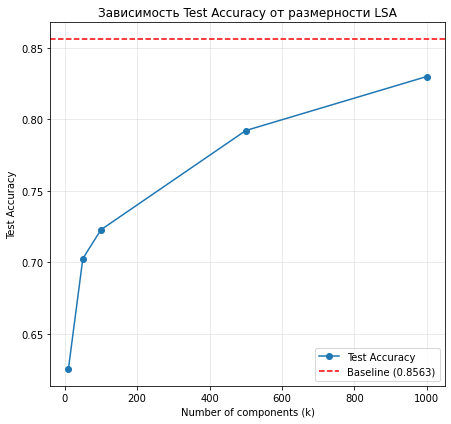


Лучшее тестовое качество: 0.829978 при k=1000
Baseline quality: 0.856289


In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res_df['k'], res_df['test_acc'], marker='o', label='Test Accuracy')
plt.axhline(y=test_acc_tfidf, color='r', linestyle='--', label=f'Baseline ({test_acc_tfidf:.4f})')
plt.xlabel('Number of components (k)')
plt.ylabel('Test Accuracy')
plt.title('Зависимость Test Accuracy от размерности LSA')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

best_idx = res_df['test_acc'].idxmax()
best_k = res_df.loc[best_idx, 'k']
best_test_acc = res_df.loc[best_idx, 'test_acc']

print(f"\nЛучшее тестовое качество: {best_test_acc:.6f} при k={best_k}")
print(f"Baseline quality: {test_acc_tfidf:.6f}")

**Несколько вопросиков**

1.  При каком $k$ получилось лучшее тестовое качество?
2.  Почему слишком маленькое $k$ может давать низкое качество?
3.  Почему слишком большое $k$ (близкое к исходному количеству слов) может не давать выигрыша или даже ухудшать результат?

**Ответ:** 
1. лучшее тестовое качество достигнуто при k=1000. 
2. слишком маленькое k приводит к high bias - модель недообучается из-за слишком сильного сжатия данных. 
3. слишком большое k yе удаляет достаточно шума из данных, увеличивает риск переобучения, вычислительно сложнее без значимого выигрыша в качестве

## Задание 9 Topic Modeling: LDA и интерпретация тем (1 балл)

LDA (Latent Dirichlet Allocation) ищет скрытые темы в корпусе документов. Мы научимся:

1.  Обучать LDA по матрице частот (BoW).
2.  Интерпретировать темы по топ-словам.
3.  (Дополнительно) использовать распределения тем как признаки для классификации.

Сначала подготовим CountVectorizer.

> **Важно:** для LDA обычно используют `CountVectorizer`, а не `TF-IDF`.

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

cv_lda = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_df=0.95,
    min_df=5,
    max_features=5000
)

X_train_lda = cv_lda.fit_transform(train['OriginalTweet'])
print(f"Размерность матрицы для LDA: {X_train_lda.shape}")

Размерность матрицы для LDA: (23410, 5000)


Пора обучить LDA. Выберите число тем `n_topics` (например, 10). Обучите модель на `train`. Это может занять некоторое время.

In [67]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=0,
    max_iter=20,
    learning_method='batch',
    n_jobs=-1
)

lda.fit(X_train_lda)

LatentDirichletAllocation(max_iter=20, n_jobs=-1, random_state=0)

Выведем топ-слова для каждой темы? Для этого напишите функцию, которая для каждой темы печатает топ-10 слов с наибольшими весами.

In [68]:
def print_top_words(model, feature_names, n_top_words=10):
    # model.components_ содержит веса слов для каждой темы
    # нужно отсортировать их и вывести соответствующие слова из feature_names

    for topic_idx, topic in enumerate(model.components_):
        # Получаем индексы топ-N слов с наибольшими весами
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Тема {topic_idx:2d}: {', '.join(top_words)}")

feature_names = cv_lda.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words=10)

Тема  0: food, 19, covid, demand, online, shopping, due, help, supply, pandemic
Тема  1: store, grocery, 19, covid, #coronavirus, people, go, like, supermarket, work
Тема  2: prices, #coronavirus, price, #covid_19, people, selling, items, like, #covid19, #covid2019
Тема  3: stay, #coronavirus, home, supermarket, shopping, safe, social, online, people, distancing
Тема  4: hand, sanitizer, #coronavirus, masks, #covid19, 2, face, fight, mask, soap
Тема  5: #coronavirus, #covid19, ..., toilet, paper, #toiletpaper, #covid, #covid_19, like, supermarket
Тема  6: prices, 19, covid, oil, #coronavirus, market, pandemic, low, demand, gas
Тема  7: workers, supermarket, staff, store, thank, grocery, #coronavirus, delivery, people, employees
Тема  8: food, panic, people, supermarket, buying, #coronavirus, shelves, 19, need, stock
Тема  9: consumer, 19, covid, #coronavirus, pandemic, new, #covid19, crisis, read, scams


1.  Выберите 3-5 тем, которые получились наиболее понятными, и словами опишите, про что эта тема (например: "продукты", "паника", "политика").
2.  Есть ли темы, которые выглядят мусорными (смесь предлогов, общих слов)? Почему так может происходить?

**Ответ:** 
1. 
    - Тема 2 (prices, #coronavirus, price, #covid_19, people, selling, items, like, #covid19, #covid2019) - обсуждение роста цен, продажи товаров по завышенным ценам.
    - Тема 4 (hand, sanitizer, #coronavirus, masks, #covid19, 2, face, fight, mask, soap) - тема о масках, санитайзерах, мытье рук для защиты от вируса.
    - Тема 7 (workers, supermarket, staff, store, thank, grocery, #coronavirus, delivery, people, employees) - выражение благодарности сотрудникам магазинов и служб доставки.
    
2. темы получаются мусорными из-за общих слов, которые имеют высокую частоту и попадают во многие темы, также из-за схлопывания смыслов в темах из-за общих слов

Теперь используем распределение тем в документе как признаки. Получите матрицы тематических распределений для `train` и `test` и обучите логистическую регрессию.

In [69]:
# lda.transform возвращает вероятность принадлежности документа к каждой из тем
X_test_lda = cv_lda.transform(test['OriginalTweet'])

X_train_topics = lda.transform(X_train_lda)
X_test_topics  = lda.transform(X_test_lda)

clf_topics = LogisticRegression(max_iter=2000, random_state=0)

X_train_topics = lda.transform(X_train_lda)
X_test_topics = lda.transform(X_test_lda)

print(f"Размерность train: {X_train_topics.shape}")
print(f"Размерность test: {X_test_topics.shape}")

Размерность train: (23410, 10)
Размерность test: (10034, 10)


In [70]:
clf_topics = LogisticRegression(max_iter=2000, random_state=0)
clf_topics.fit(X_train_topics, y_train)

pred_train_topics = clf_topics.predict(X_train_topics)
pred_test_topics = clf_topics.predict(X_test_topics)

train_acc_topics = accuracy_score(y_train, pred_train_topics)
test_acc_topics = accuracy_score(y_test, pred_test_topics)

print(f"LDA-topics train acc: {train_acc_topics}")
print(f"LDA-topics test acc: {test_acc_topics}")

LDA-topics train acc: 0.6331909440410081
LDA-topics test acc: 0.6322503488140323


1.  Как качество классификации на темах (всего 10 признаков) сравнивается с TF-IDF baseline?
2.  Почему темы могут быть хуже или лучше как признаки в данной задаче?

**Ответ:** 
1. качество классификации на темах LDA значительно хуже, чем TF-IDF baseline
2. 
    - мало признаков, всего 10 признаков недостаточно для тонкого различения тональности
    - неконтролируемое обучение, так как LDA не знает о тональности текстов
    - одна тема отражает разные эмоции, тема "магазины" может содержать как положительные, так и отрицательные твиты

## Бонус Word2Vec (CBOW vs Skip-gram) (до +1 балла)


**Идея:** обучим нейросетевые эмбеддинги Word2Vec двумя способами (CBOW и Skip-gram), сравним, какие слова они считают похожими, и попробуем классификацию через усреднение векторов слов.

Библиотека `gensim` принимает на вход список списков токенов. Давайте подготовим корпуса токенов.

In [71]:
# Применяем токенайзер к каждому твитту
# Должен получиться list of lists: [['this', 'is', ...], ['another', 'tweet', ...]]

tokenized_train =  [custom_tokenizer(text) for text in train['OriginalTweet']] # your code here # (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧
tokenized_test  = [custom_tokenizer(text) for text in test['OriginalTweet']] # your code here (нужно для последней части)

In [72]:
print(f"Количество твитов в train: {len(tokenized_train)}")
print(f"Количество твитов в test: {len(tokenized_test)}")

Количество твитов в train: 23410
Количество твитов в test: 10034


Мы добрались наконец-то до обучения Word2Vec.

In [73]:
from gensim.models import Word2Vec

w2v_params = dict(
    vector_size= 100 ,
    window= 5,
    min_count= 5,
    workers= 5 ,
    sg=0 ,          # 0 = CBOW, 1 = Skip-gram
    seed=42
)

# Обучаем CBOW

print("Training CBOW...")
w2v_cbow = Word2Vec(sentences=tokenized_train, **w2v_params)

# Обучаем Skip-gram

print("Training Skip-gram...")
w2v_params_sg = w2v_params.copy()
w2v_params_sg["sg"] = 1
w2v_sg = Word2Vec(sentences=tokenized_train,**w2v_params_sg)

Training CBOW...
Training Skip-gram...


In [74]:
print(f"Размер словаря CBOW: {len(w2v_cbow.wv.key_to_index)}")
print(f"Размер словаря Skip-gram: {len(w2v_sg.wv.key_to_index)}")

Размер словаря CBOW: 8483
Размер словаря Skip-gram: 8483


Давайте еще сравним ближайших соседей. Выберите 5–7 слов, которые точно есть в корпусе (например: "covid", "virus", "good", "panic", "lockdown")

In [75]:
test_words = ['covid', 'virus', 'good', 'panic', 'lockdown', 'mask', 'store']

for w in test_words:
    if w in w2v_cbow.wv.key_to_index and w in w2v_sg.wv.key_to_index:
        print(f"\nWORD: {w}")
        print("CBOW:", [x[0] for x in w2v_cbow.wv.most_similar(w, topn=5)])
        print("SG  :", [x[0] for x in w2v_sg.wv.most_similar(w, topn=5)])
    else:
        print(f"\nWord '{w}' not in vocabulary")


WORD: covid
CBOW: ['controlling', 'ranchers', 'post-covid', 'democratic', 'update']
SG  : ['coronavirus', 'potential', 'rapid', 'illness', 'largely']

WORD: virus
CBOW: ['corona', 'spreading', 'spread', 'fight', 'prevent']
SG  : ['corona', 'disease', 'spreading', 'cure', 'deadly']

WORD: good
CBOW: ['bit', '..', 'thing', 'wrong', 'something']
SG  : ['bad', 'great', 'always', 'seems', 'idea']

WORD: panic
CBOW: ['bulk', 'stop', 'believed', 'hoarding', 'guns']
SG  : ['panic-buying', 'guns', 'selfish', 'bulk', 'panicking']

WORD: lockdown
CBOW: ['situation', 'already', 'prepare', 'control', 'may']
SG  : ['lock', 'imposed', 'movement', 'overseas', 'malaysia']

WORD: mask
CBOW: ['gloves', 'bandana', 'wear', 'masks', 'wearing']
SG  : ['gloves', 'wear', 'n95', 'wearing', 'masks']

WORD: store
CBOW: ['stores', 'line', 'pharmacy', 'walmart', 'clerks']
SG  : ['grocery', 'stores', 'pharmacy', 'clerk', 'restaurant']


1.  Где соседи выглядят более осмысленными - у CBOW или Skip-gram?
2.  Заметили ли вы разницу в том, какие именно ассоциации ловят модели (синонимы, контекст)?


**Ответ:** 
1. У Skip-gram
2. CBOW - больше контекстных, Skip-gram - больше синонимов

Попробуем сделать классификацию твитов через усреднение эмбеддингов. Сделаем "вектор твита" как среднее арифметическое эмбеддингов всех его слов.

In [76]:
import numpy as np

def tweet_embedding(tokens, model, dim=100):
    # 1. Создаем список векторов для слов, которые есть в модели
    vectors = []
    for word in tokens:
        if word in model.wv.key_to_index:
            vectors.append(model.wv[word])
            
    # 2. Если слов нет (пустой список), возвращаем вектор из нулей
    if len(vectors) == 0:
        return np.zeros(dim)
    
    # 3. Иначе возвращаем среднее (mean)
    return np.mean(vectors, axis=0)

# Строим матрицы
X_train_w2v_cbow = np.array([tweet_embedding(tokens, w2v_cbow) for tokens in tokenized_train])
X_test_w2v_cbow  = np.array([tweet_embedding(tokens, w2v_cbow) for tokens in tokenized_test])

X_train_w2v_sg = np.array([tweet_embedding(tokens, w2v_sg) for tokens in tokenized_train])
X_test_w2v_sg  = np.array([tweet_embedding(tokens, w2v_sg) for tokens in tokenized_test])

# Оцениваем классификатор
clf = LogisticRegression(max_iter=2000, random_state=0)
clf.fit(X_train_w2v_cbow, y_train)
pred_cbow = clf.predict(X_test_w2v_cbow)
acc_cbow = accuracy_score(y_test, pred_cbow)

# your code here: fit/predict для CBOW и для SG отдельно
clf_sg = LogisticRegression(max_iter=2000, random_state=0)
clf_sg.fit(X_train_w2v_sg, y_train)
pred_sg = clf_sg.predict(X_test_w2v_sg)
acc_sg = accuracy_score(y_test, pred_sg)

print("W2V-CBOW test acc:", acc_cbow)
print("W2V-SG test acc:", acc_sg)

W2V-CBOW test acc: 0.6781941399242575
W2V-SG test acc: 0.7219453856886585


1.  Сравните качество Word2Vec-подхода с TF-IDF.
2.  Почему простое усреднение эмбеддингов часто проигрывает TF-IDF на задаче анализа тональности?
3.  В каких случаях эмбеддинги могли бы сработать лучше (интуитивно)?

**Ответ:** 
1.  Word2Ve - 0.6799, TF-IDF - 0.8562
2.  -
3.  -

## Заключение

Вы попробовали 4 разных подхода к векторизации:

- Bag-of-Words / CountVectorizer (просто частоты)

- TF-IDF (взвешенные частоты)

- LSA (снижение размерности)

- Word2Vec (плотные эмбеддинги)

Вопрос такой. Какой метод показал лучшее соотношение качество / сложность / время? Если бы вы делали продакшн-систему для фильтрации токсичных комментариев в реальном времени, что бы вы выбрали?

- Лучшее качество и удобность у TF-IDF. Для продакшн-системы я бы выбрал TF-IDF.

#### your text here ( •̀ ω •́ )✧

Хочется отметить структурированность подаваемой для выполнения домашки, это очень удобно и логически понятно. Очень интересная тема, которую можно ощутить на выводимых результатах. Сложновато работать со сравнительным анализом, так как в начале не было упоминаний сохранить для дальнейшего анализа.

В общем и целом домашка классная, было интересно, хотя по началу казалось, что не осилю всё.